<a href="https://colab.research.google.com/github/ttsupra30/QM2/blob/main/absolutefinalQM_updated_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Method Overview
**Objective**: This study examines the relationship between gambling expenditure and labour market conditions in Australia, focusing on unemployment rates across eight regions and at the national level. The analysis proceeds in two stages:

**Panel regression** to identify robust **correlations** while controlling for unobserved regional heterogeneity.

**Granger causality analysis** to examine lead–lag dynamics and temporal **causation**.

This two-step approach allows the study to separate contemporaneous association from dynamic predictive causality.

# 1. Data
**1.1 Unit of Analysis**

Cross-sectional unit: Australian regions $i = ACT, NSW, \dots, WA$

Time unit: annual observations $t=1,\dots,T$

Balanced panel: each region observed over the same time span

**1.2 Key Variables**

*  Dependent or independent relies on the test direction

*  $Gambling_t^{(i)}$ : real per-capita gambling expenditure $(\$)$

*  $Unemp_t^{(i)}$ : regional unemployment rate $(\%)$

**1.3 Transformations**

$Gambling_t^{(i)} → ln(Gambling_t^{(i)})$

**1.4 Control variables ($X_t^{(i)}$):**

Quarterly Population Estimates (Persons)

Wage price index

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
!pip install linearmodels
from linearmodels.panel import PanelOLS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 11.8 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving QM2.csv to QM2.csv


In [ ]:
# Read data
df = pd.read_csv('QM2.csv')
df.head()

,State,Year,Real per capita total gambling expenditure value ($),Wage price index,Unemployment rate (%),Final consumption expenditure minus net loss from gambling ( Millions $)
0,ACT,1998–99,1739.17,69.25,6.00,11739.0
1,ACT,1999–00,1757.75,70.98,5.04,12528.0
2,ACT,2000–01,1761.04,73.50,4.58,12807.0
3,ACT,2001–02,1718.74,75.80,4.52,13462.0
4,ACT,2002–03,1723.14,78.40,4.26,14253.0


In [ ]:
# Convert year columns
df.dropna(subset=['Year'], inplace=True)
df['year'] = df['Year'].str[-2:].astype(int) + 2000
df.loc[df['year'] > 2025, 'year'] -= 100
df

,State,Year,Real per capita total gambling expenditure value ($),Wage price index,Unemployment rate (%),Final consumption expenditure minus net loss from gambling ( Millions $),year
0,ACT,1998–99,1739.17,69.25,6.00,11739.0,1999
1,ACT,1999–00,1757.75,70.98,5.04,12528.0,2000
2,ACT,2000–01,1761.04,73.50,4.58,12807.0,2001
3,ACT,2001–02,1718.74,75.80,4.52,13462.0,2002
4,ACT,2002–03,1723.14,78.40,4.26,14253.0,2003
...,...,...,...,...,...,...,...
203,WA,2019–20,787.04,132.48,6.02,126209.0,2020
204,WA,2020–21,971.28,134.43,6.09,129351.0,2021
205,WA,2021–22,946.83,137.35,3.81,137505.0,2022
206,WA,2022–23,925.11,142.58,3.56,144880.0,2023


In [ ]:
# Relabel the columns
STATE = "State"
YEAR  = "year"
GAMB  = "Real per capita total gambling expenditure value ($)"
UNEMP = "Unemployment rate (%)"
WPI   = "Wage price index"
POP   = "Final consumption expenditure minus net loss from gambling ( Millions $)"

# Keep only necessary columns
df = df[[STATE, YEAR, GAMB, UNEMP, WPI, POP]].copy()

# Ensure numeric data of all variables
df[[GAMB, UNEMP, WPI, POP]] = df[[GAMB, UNEMP, WPI, POP]].apply(
    pd.to_numeric, errors="coerce"
)

# Log gambling (must be > 0)
df = df[df[GAMB] > 0]
df["log_gambling"] = np.log(df[GAMB])

# Log controls (must be > 0)
df = df[df[POP] > 0]
df["log_pop"] = np.log(df[POP])

# Drop missing and set panel index
df = df.dropna(subset=[STATE, YEAR, "log_gambling", UNEMP, WPI, "log_pop"])
df = df.set_index([STATE, YEAR]).sort_index()

df

Real per capita total gambling expenditure value ($)  \
State year                                                         
ACT   1999                                            1739.17      
      2000                                            1757.75      
      2001                                            1761.04      
      2002                                            1718.74      
      2003                                            1723.14      
...                                                       ...      
WA    2020                                             787.04      
      2021                                             971.28      
      2022                                             946.83      
      2023                                             925.11      
      2024                                             896.41      

            Unemployment rate (%)  Wage price index  \
State year                                            
ACT   1999                   6.00             69.25   
      2000                   5.04             70.98   
      2001                   4.58             73.50   
      2002                   4.52             75.80   
      2003                   4.26             78.40   
...                           ...               ...   
WA    2020                   6.02            132.48   
      2021                   6.09            134.43   
      2022                   3.81            137.35   
      2023                   3.56            142.58   
      2024                   3.73            148.85   

            Final consumption expenditure minus net loss from gambling ( Millions $)  \
State year                                                                             
ACT   1999                                            11739.0                          
      2000                                            12528.0                          
      2001                                            12807.0                          
      2002                                            13462.0                          
      2003                                            14253.0                          
...                                                       ...                          
WA    2020                                           126209.0                          
      2021                                           129351.0                          
      2022                                           137505.0                          
      2023                                           144880.0                          
      2024                                           149403.0                          

            log_gambling    log_pop  
State year                           
ACT   1999      7.461163   9.370672  
      2000      7.471790   9.435721  
      2001      7.473660   9.457747  
      2002      7.449347   9.507626  
      2003      7.451903   9.564723  
...                  ...        ...  
WA    2020      6.668279  11.745695  
      2021      6.878615  11.770285  
      2022      6.853120  11.831416  
      2023      6.829913  11.883661  
      2024      6.798398  11.914403  

[208 rows x 6 columns]

# 3. Models
# 3.1 Time-series OLS + Panel Regression
**3.1.A Model A: Gambling leads unemployment**

*   Test of gambling → later unemployment




**Model A1: National time-series OLS (Australia as a whole)**

$$
Unemp_t
=
\alpha
+\sum_{k=0}^{p}\beta_k\,\ln(Gambling_{t-k})
+\delta_2 \ln(Pop_t)
+\delta_3 WPI_t
+\varepsilon_t
$$

**Model A2: Single-region time-series OLS** (e.g. NSW only)

* Same equation - just applied to one region.

$$
Unemp_{i,t}
=
\alpha
+\sum_{k=0}^{p}\beta_k\,\ln(Gambling_{i,t-k})
+\delta_2 \ln(Pop_{i,t})
+\delta_3 WPI_{i,t}
+\varepsilon_{i,t}
$$

\begin{align}
H_0 &: \beta_0 = \beta_1 = \cdots = \beta_p = 0
&& \text{(Gambling expenditure has no association with unemployment)} \\
H_1 &: \exists \; k \in \{0,\dots,p\} \text{ such that } \beta_k \neq 0
&& \text{(Gambling expenditure is associated with unemployment at some lag)}
\end{align}

Both two times series OLS test for “Does gambling correlate with later unemployment within this specific region over time?”

In [ ]:
def ts_ols_modelA(ts_df, *, year_col=YEAR, p=1):

    d = (
        ts_df[[year_col, UNEMP, "log_gambling", "log_pop", WPI]]
        .dropna()
        .sort_values(year_col)
        .copy()
    )

    # Lag gambling INCLUDING contemporaneous term (k = 0)
    for k in range(0, p + 1):
        d[f"g_L{k}"] = d["log_gambling"].shift(k)

    rhs = (
        [f"g_L{k}" for k in range(0, p + 1)]
        + [ "log_pop", WPI]
    )

    d = d.dropna(subset=[UNEMP] + rhs)

    y = d[UNEMP].astype(float)
    X = sm.add_constant(d[rhs].astype(float))

    res = sm.OLS(y, X).fit(
        cov_type="HAC",
        cov_kwds={"maxlags": p}
    )

    return res, d


In [ ]:
#Call National level
df_flat = df.reset_index()

nat = (
    df_flat
    .groupby(YEAR)[[UNEMP, "log_gambling", "log_pop", WPI]]
    .mean()
    .reset_index()
)

res_nat, used_nat = ts_ols_modelA(nat, year_col=YEAR, p=5)
print(res_nat.summary())


                              OLS Regression Results                             
Dep. Variable:     Unemployment rate (%)   R-squared:                       0.729
Model:                               OLS   Adj. R-squared:                  0.549
Method:                    Least Squares   F-statistic:                     152.0
Date:                   Fri, 09 Jan 2026   Prob (F-statistic):           7.14e-11
Time:                           15:30:26   Log-Likelihood:                -7.5756
No. Observations:                     21   AIC:                             33.15
Df Residuals:                         12   BIC:                             42.55
Df Model:                              8                                         
Covariance Type:                     HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

In [ ]:
# Call National level Exclude Northern Territory
df_flat_noNT = df_flat[df_flat["State"] != "NT"].copy()
# National series excluding NT (average across remaining states)
nat_noNT = (
    df_flat_noNT
    .groupby(YEAR)[[UNEMP, "log_gambling","log_pop", WPI]]
    .mean()
    .reset_index()
)

res_nat_noNT, used_nat_noNT = ts_ols_modelA(
    nat_noNT,
    year_col=YEAR,
    p=5
)

print(res_nat_noNT.summary())


                              OLS Regression Results                             
Dep. Variable:     Unemployment rate (%)   R-squared:                       0.810
Model:                               OLS   Adj. R-squared:                  0.683
Method:                    Least Squares   F-statistic:                     134.5
Date:                   Fri, 09 Jan 2026   Prob (F-statistic):           1.47e-10
Time:                           15:30:26   Log-Likelihood:                -5.2632
No. Observations:                     21   AIC:                             28.53
Df Residuals:                         12   BIC:                             37.93
Df Model:                              8                                         
Covariance Type:                     HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

In [ ]:
#Call Regional level
region_nsw = df_flat[df_flat["State"] == "NSW"][
    [YEAR, UNEMP, "log_gambling", "log_pop", WPI]
]

res_nsw, used_nsw = ts_ols_modelA(region_nsw, year_col=YEAR, p=3)
print(res_nsw.summary())

                              OLS Regression Results                             
Dep. Variable:     Unemployment rate (%)   R-squared:                       0.637
Model:                               OLS   Adj. R-squared:                  0.501
Method:                    Least Squares   F-statistic:                     8.943
Date:                   Fri, 09 Jan 2026   Prob (F-statistic):           0.000221
Time:                           15:30:26   Log-Likelihood:                -12.853
No. Observations:                     23   AIC:                             39.71
Df Residuals:                         16   BIC:                             47.66
Df Model:                              6                                         
Covariance Type:                     HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

In [ ]:
# MAKE ONE RESULT TABLE (National, 8 states, National excl NT) ======

from statsmodels.iolib.summary2 import summary_col
import numpy as np
import pandas as pd

# ---------- helpers ----------
def cumulative_gambling_effect(res, p):
    return sum(float(res.params.get(f"g_L{k}", 0.0)) for k in range(0, p + 1))

def wald_pvalue_gambling_raw(res, p):
    terms = [f"g_L{k}" for k in range(0, p + 1)]
    hypothesis = " = ".join(terms) + " = 0"
    wt = res.wald_test(hypothesis, scalar=True)  # scalar=True avoids FutureWarning
    return float(wt.pvalue)

def format_p(pval, decimals=6):
    # raw numeric p-value, formatted consistently; if extremely tiny, show scientific
    if pval == 0.0:
        return "0"
    if pval < 10**(-decimals):
        return f"{pval:.2e}"
    return f"{pval:.{decimals}f}"

# ---------- settings ----------
P = 5   # lag length used in ts_ols_modelA (must match your estimation)
EXCL = "NT"      # exclude NT for the robustness national series

# ---------- flatten panel ----------
df_flat = df.reset_index()

# ---------- National (All) ----------
nat_all = (
    df_flat.groupby(YEAR)[[UNEMP, "log_gambling", "log_pop", WPI]]
    .mean()
    .reset_index()
)
model_nat_all, _ = ts_ols_modelA(nat_all, year_col=YEAR, p=P)

# ---------- State models ----------
state_models, state_names = [], []
for st in sorted(df_flat["State"].dropna().unique()):
    sub = df_flat[df_flat["State"] == st][
        [YEAR, UNEMP, "log_gambling",  "log_pop", WPI]
    ]
    res, _ = ts_ols_modelA(sub, year_col=YEAR, p=P)
    state_models.append(res)
    state_names.append(st)

# ---------- National (exclude NT) ----------
nat_excl = (
    df_flat[df_flat["State"] != EXCL]
    .groupby(YEAR)[[UNEMP, "log_gambling",  "log_pop", WPI]]
    .mean()
    .reset_index()
)
model_nat_excl, _ = ts_ols_modelA(nat_excl, year_col=YEAR, p=P)

# ---------- build summary_col table ----------
models = [model_nat_all] + state_models + [model_nat_excl]
names  = ["National (All)"] + state_names + [f"National (excl {EXCL})"]

regressor_order = (
    ["const"]
    + [f"g_L{k}" for k in range(0, P + 1)]
    + [ "log_pop", WPI]
)

# Keep info_dict minimal to avoid duplicated lines
table = summary_col(
    models,
    stars=True,
    float_format="%0.3f",
    model_names=names,
    regressor_order=regressor_order,
    info_dict={
        "N": lambda x: f"{int(x.nobs)}"
    },
)

# ---------- append extra rows (aligned as normal rows) ----------
df_table = table.tables[0]

cum_vals = [f"{cumulative_gambling_effect(m, P):.3f}" for m in models]
wald_vals = [format_p(wald_pvalue_gambling_raw(m, P), decimals=6) for m in models]

df_table.loc[f"Cumulative gambling effect (sum g_L0..g_L{P})"] = cum_vals
df_table.loc[f"Wald p-value (H0: g_L0..g_L{P} = 0)"] = wald_vals

# ---------- print in a “parallel” aligned way (avoid wrapping) ----------
with pd.option_context(
    "display.width", 4000,
    "display.max_columns", None,
    "display.max_colwidth", None
):
    print(df_table.to_string())


                                            National (All)         ACT         NSW          NT         QLD          SA         TAS         VIC          WA National (excl NT)
const                                           234.773***  134.541***  224.949***   96.387***  249.251***  262.080***  113.552***    71.452**   130.086**          137.692**
                                                  (44.953)    (49.072)    (46.974)    (19.783)    (21.730)    (34.705)    (34.437)    (34.127)    (55.881)           (62.294)
g_L0                                              6.614***    -1.648**      -0.496       0.167   -1.917***   -2.456***      -1.255       1.020      -0.335          -3.252***
                                                   (2.196)     (0.837)     (1.191)     (0.126)     (0.624)     (0.562)     (0.897)     (0.747)     (2.272)            (1.211)
g_L1                                                2.063*       1.131   -8.861***       0.074   -7.192***   -4.055***   -3.762***

In [ ]:
import numpy as np
import pandas as pd

# ---------- Sensitivity test over lag length p ----------

P_MAX = 8
rows = []

for p in range(0, P_MAX + 1):

    # run NATIONAL model (example: national average series)
    res, used = ts_ols_modelA(nat_all, year_col=YEAR, p=p)

    # cumulative effect
    cum_eff = cumulative_gambling_effect(res, p)

    # Joint Wald test: g_L0 = g_L1 = ... = g_Lp = 0
    terms = [f"g_L{k}" for k in range(0, p + 1)]

    # Build restriction matrix R so that R @ beta = 0 tests those coefficients
    param_names = list(res.params.index)
    idx = [param_names.index(t) for t in terms if t in param_names]

    if len(idx) == 0:
        w_stat, w_pval = np.nan, np.nan
    else:
        R = np.zeros((len(idx), len(param_names)))
        for r, j in enumerate(idx):
            R[r, j] = 1.0
        q = np.zeros(len(idx))
        wt = res.wald_test((R, q), scalar=True)

        # robust scalar extraction
        w_stat = np.asarray(wt.statistic).item()
        w_pval = np.asarray(wt.pvalue).item()

    rows.append({
        "p": p,
        "Cumulative gambling effect": cum_eff,
        "Wald stat": w_stat,
        "Wald p-value": w_pval,
        "N": int(res.nobs),
    })

# build table
sens_table = pd.DataFrame(rows).set_index("p")

# making table look more aesthetic
with pd.option_context(
    "display.float_format", "{:.6g}".format,
    "display.width", 2000
):
    print(sens_table)


   Cumulative gambling effect   Wald stat  Wald p-value   N
p                                                          
0                  -0.0228954 0.000157472      0.989988  26
1                   -0.770368    0.195708      0.906781  25
2                     5.60153     53.3819   1.51995e-11  24
3                     11.9744     353.801   2.65024e-75  23
4                     26.0333     278.584   4.01041e-58  22
5                      24.855     954.401  6.49585e-203  21
6                     24.1598     2132.97             0  20
7                     18.6504       14303             0  19
8                     13.0249       13321             0  18


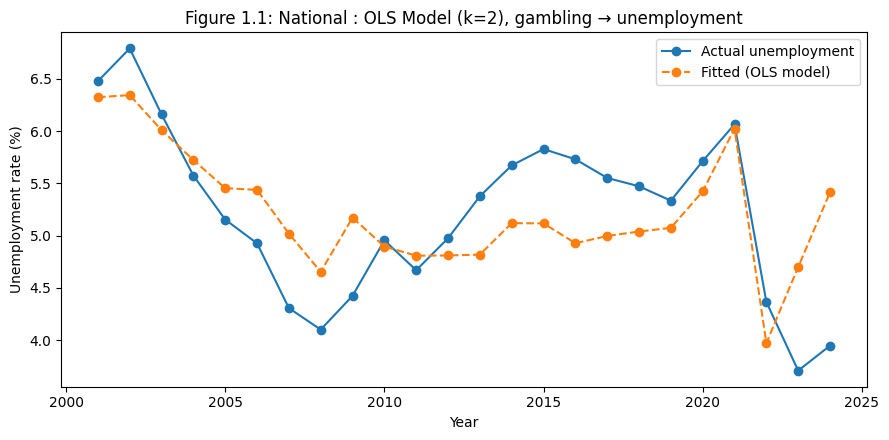

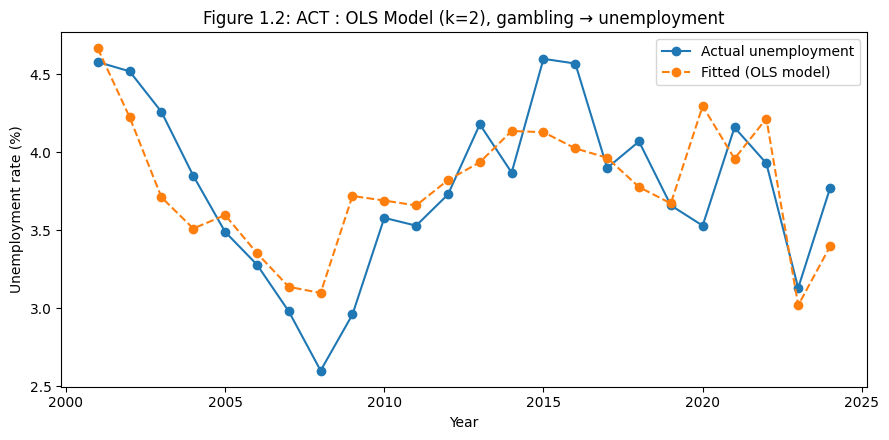

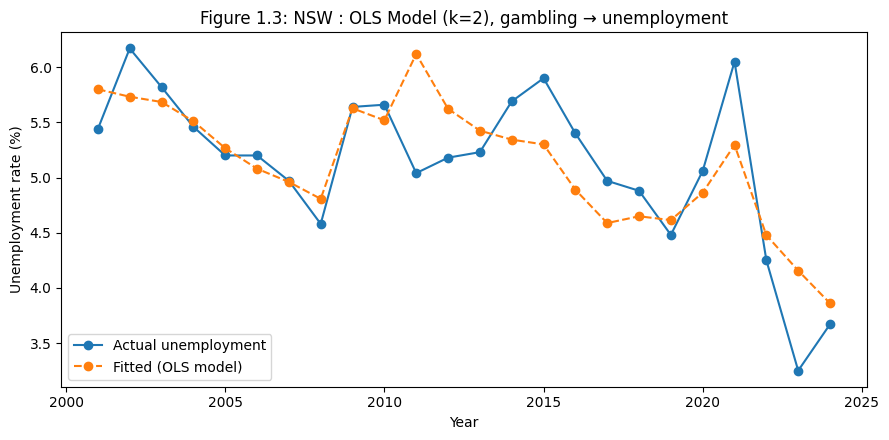

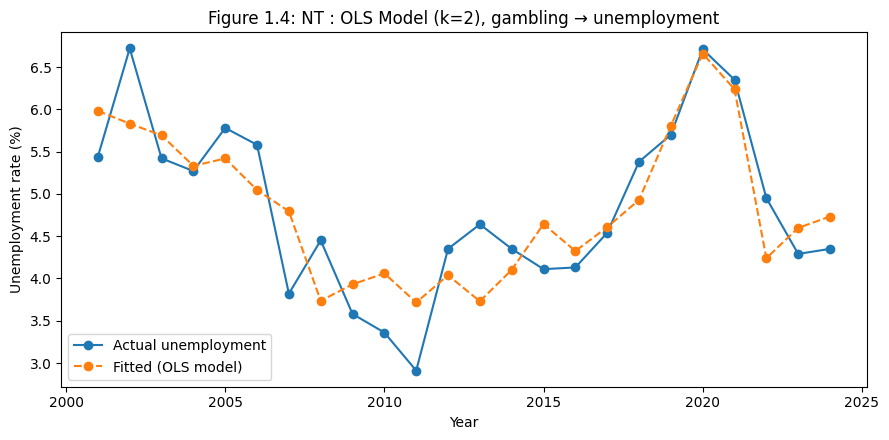

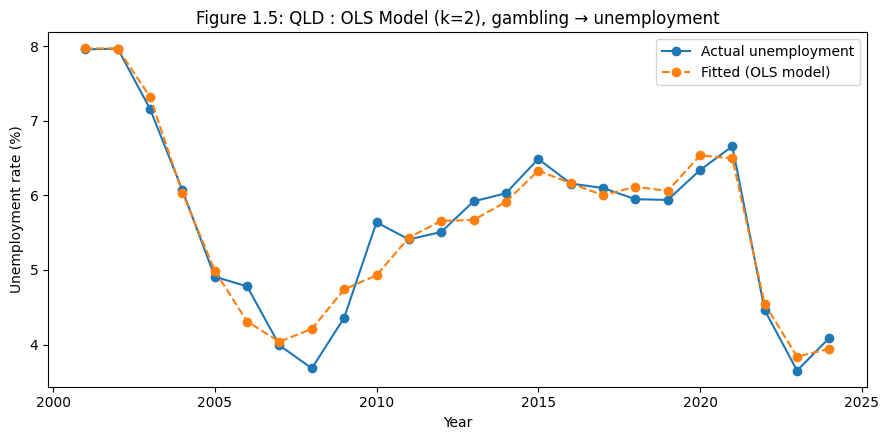

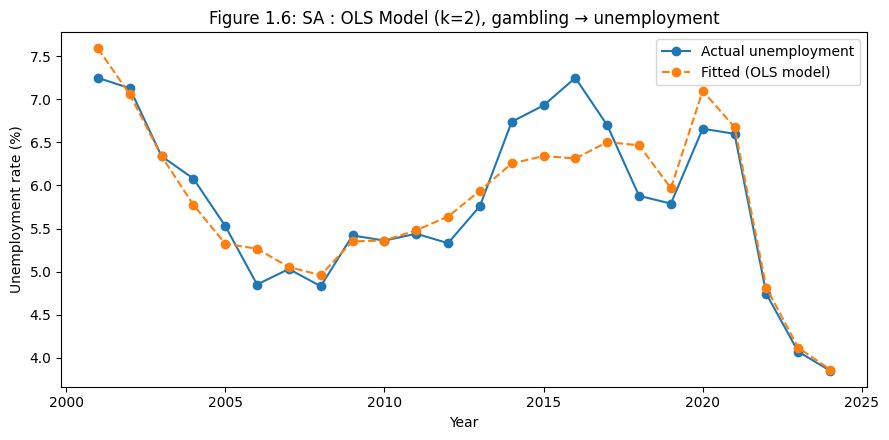

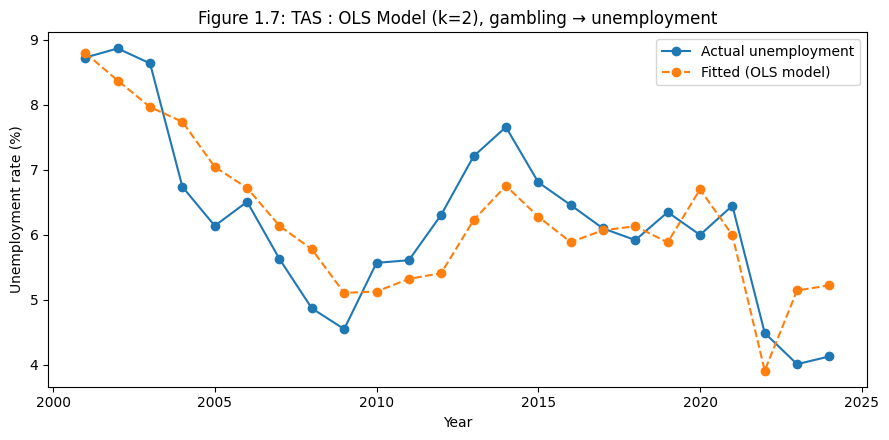

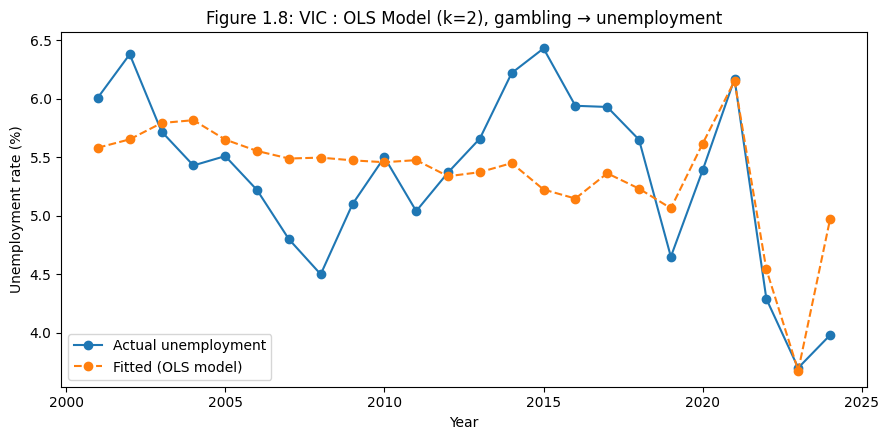

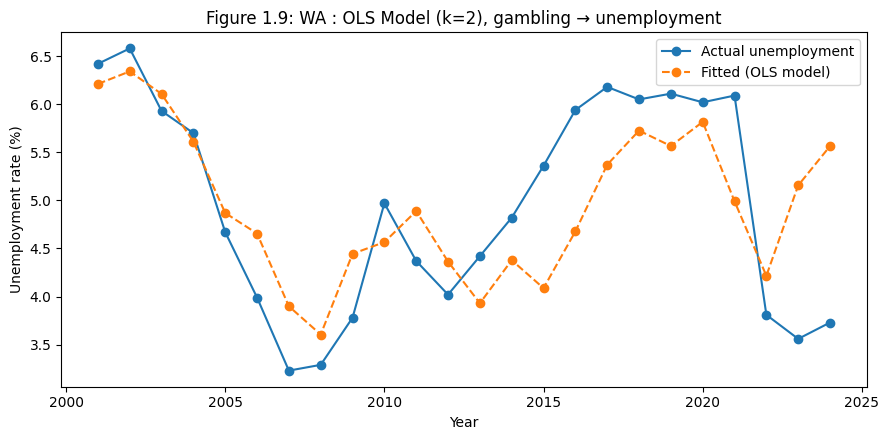

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

#graphs for model A (model vs actual)
def ts_ols_modelA(ts_df, *, year_col, p):
    """
    Unemployment_t ~ g_L0..g_Lp + log_pop + WPI
    HAC SEs with maxlags=p
    Returns (res, d_used) where d_used includes the lag columns.
    """
    d = (
        ts_df[[year_col, UNEMP, "log_gambling", "log_pop", WPI]]
        .dropna()
        .sort_values(year_col)
        .copy()
    )

    for k in range(0, p + 1):
        d[f"g_L{k}"] = d["log_gambling"].shift(k)

    rhs = [f"g_L{k}" for k in range(0, p + 1)] + ["log_pop", WPI]
    d = d.dropna(subset=[UNEMP] + rhs)

    y = d[UNEMP].astype(float)
    X = sm.add_constant(d[rhs].astype(float))

    res = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": p})
    return res, d


def plot_actual_vs_fitted_modelA(ts_df, label, *, year_col, p, fig_number):
    """
    Plots Actual vs Fitted unemployment from Model A
    """
    res, d_used = ts_ols_modelA(ts_df, year_col=year_col, p=p)

    rhs = [f"g_L{k}" for k in range(0, p + 1)] + ["log_pop", WPI]
    X_used = sm.add_constant(d_used[rhs].astype(float))
    fitted = res.predict(X_used)

    plt.figure(figsize=(9, 4.5))
    plt.plot(
        d_used[year_col],
        d_used[UNEMP],
        marker="o",
        label="Actual unemployment"
    )
    plt.plot(
        d_used[year_col],
        fitted,
        marker="o",
        linestyle="--",
        label="Fitted (OLS model)"
    )
#start from figure 1.1
    plt.title(
        f"Figure {fig_number}: {label} : OLS Model (k={p}), gambling → unemployment"
    )
    plt.xlabel("Year")
    plt.ylabel("Unemployment rate (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return res


# running functions
def run_all_plots_modelA(df_flat, *, p=2, section=1):
    fig_counter = 1

    # National (all states)
    nat_all = (
        df_flat
        .groupby(YEAR)[[UNEMP, "log_gambling", "log_pop", WPI]]
        .mean()
        .reset_index()
    )

    plot_actual_vs_fitted_modelA(
        nat_all,
        "National",
        year_col=YEAR,
        p=p,
        fig_number=f"{section}.{fig_counter}"
    )
    fig_counter += 1

    # State-level plots
    states = sorted(df_flat[STATE].dropna().unique())
    for st in states:
        st_df = df_flat[df_flat[STATE] == st][
            [YEAR, UNEMP, "log_gambling", "log_pop", WPI]
        ].copy()

        plot_actual_vs_fitted_modelA(
            st_df,
            st,
            year_col=YEAR,
            p=p,
            fig_number=f"{section}.{fig_counter}"
        )
        fig_counter += 1


# call function
df_flat = df.reset_index() # Re initialise df_flat
run_all_plots_modelA(df_flat, p=2, section=1)

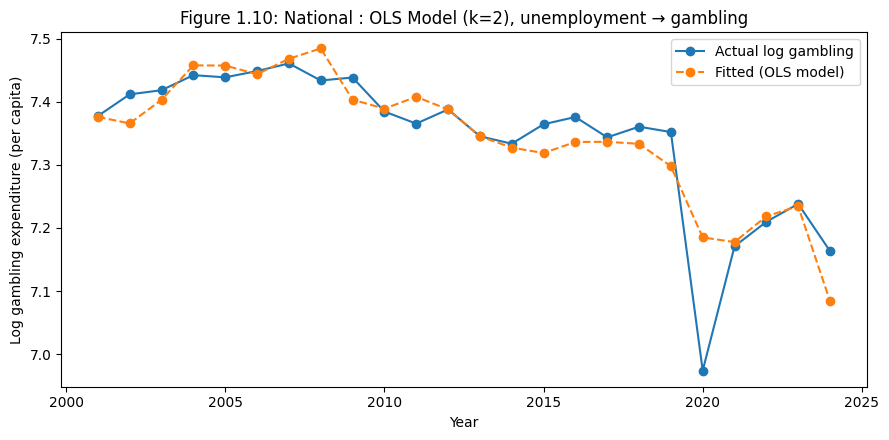

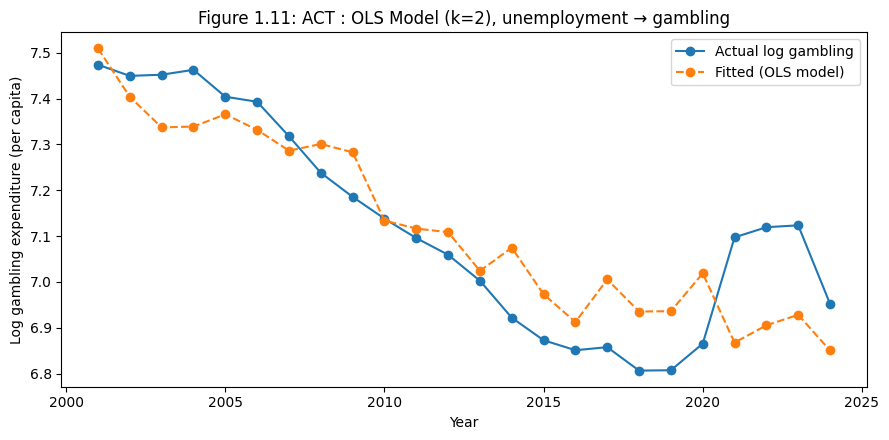

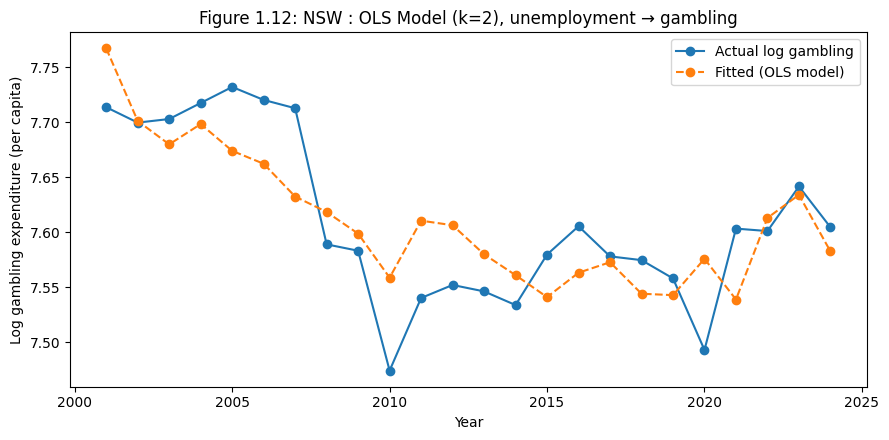

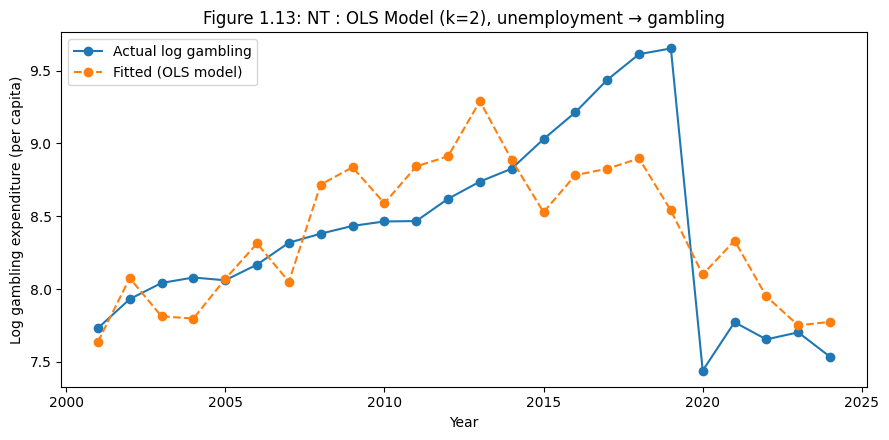

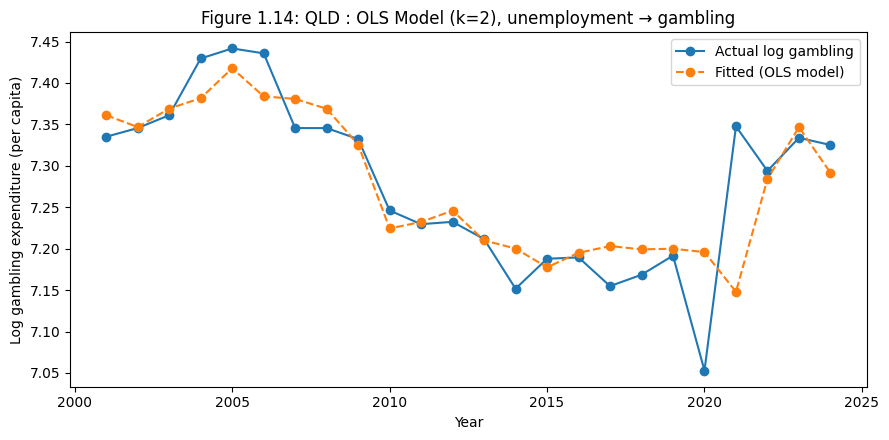

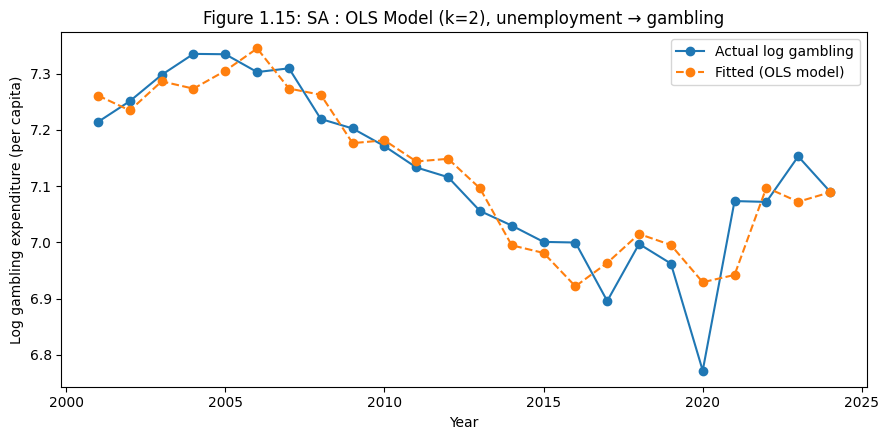

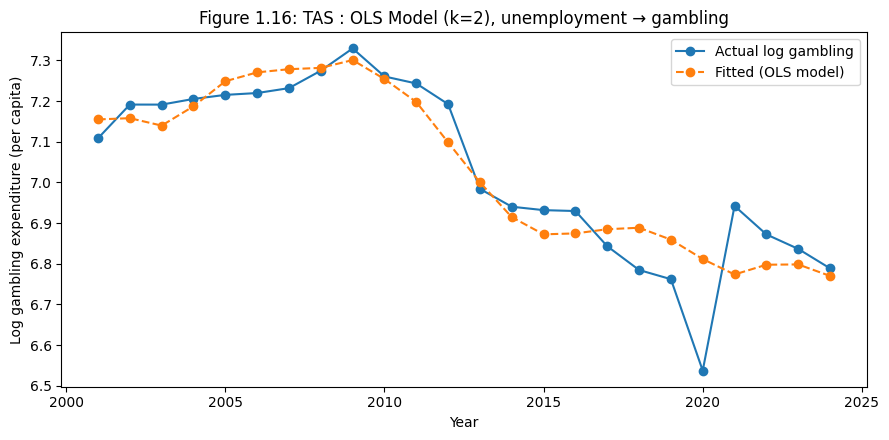

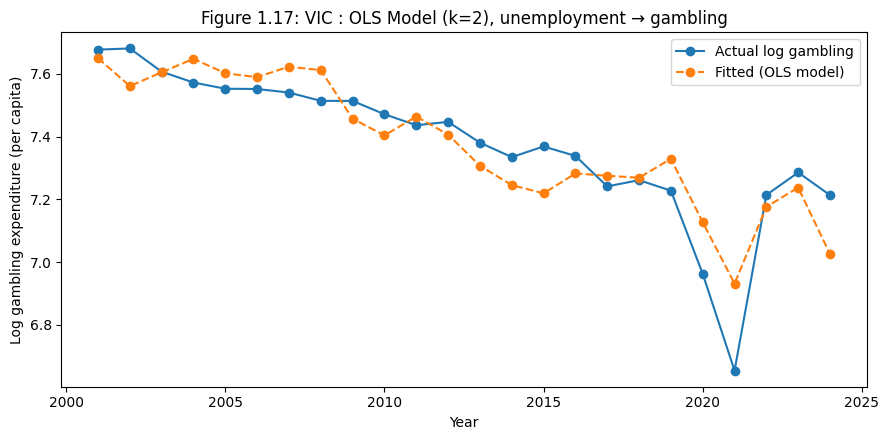

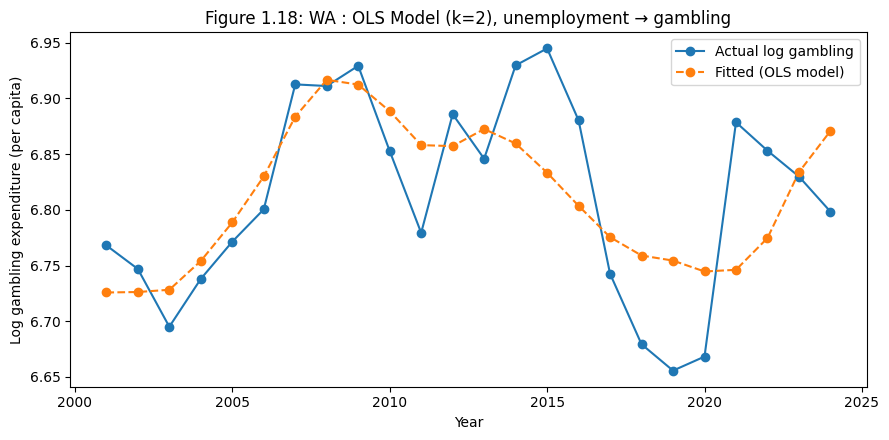

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -model B
def ts_ols_modelB(ts_df, *, year_col, p):

    d = (
        ts_df[[year_col, UNEMP, "log_gambling", "log_pop", WPI]]
        .dropna()
        .sort_values(year_col)
        .copy()
    )

    for k in range(0, p + 1):
        d[f"u_L{k}"] = d[UNEMP].shift(k)

    rhs = [f"u_L{k}" for k in range(0, p + 1)] + ["log_pop", WPI]
    d = d.dropna(subset=["log_gambling"] + rhs)

    y = d["log_gambling"].astype(float)
    X = sm.add_constant(d[rhs].astype(float))

    res = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": p})
    return res, d

#actual vs model
def plot_actual_vs_fitted_modelB(ts_df, label, *, year_col, p, fig_number):

    res, d_used = ts_ols_modelB(ts_df, year_col=year_col, p=p)

    rhs = [f"u_L{k}" for k in range(0, p + 1)] + ["log_pop", WPI]
    X_used = sm.add_constant(d_used[rhs].astype(float))
    fitted = res.predict(X_used)

    plt.figure(figsize=(9, 4.5))
    plt.plot(d_used[year_col], d_used["log_gambling"], marker="o", label="Actual log gambling")
    plt.plot(d_used[year_col], fitted, marker="o", linestyle="--", label="Fitted (OLS model)")
    plt.title(f"Figure {fig_number}: {label} : OLS Model (k={p}), unemployment → gambling")
    plt.xlabel("Year")
    plt.ylabel("Log gambling expenditure (per capita)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return res


def run_all_plots_modelB(df_flat, *, p=2, start_fig=10):
    """
    Produces:
      Figure 1.10 onward
    """
    fig_counter = start_fig

    # National
    nat_all = (
        df_flat
        .groupby(YEAR)[[UNEMP, "log_gambling", "log_pop", WPI]]
        .mean()
        .reset_index()
    )

    plot_actual_vs_fitted_modelB(
        nat_all,
        "National",
        year_col=YEAR,
        p=p,
        fig_number=f"1.{fig_counter}"
    )
    fig_counter += 1

    # States
    states = sorted(df_flat[STATE].dropna().unique())
    for st in states:
        st_df = df_flat[df_flat[STATE] == st][
            [YEAR, UNEMP, "log_gambling", "log_pop", WPI]
        ].copy()

        plot_actual_vs_fitted_modelB(
            st_df,
            st,
            year_col=YEAR,
            p=p,
            fig_number=f"1.{fig_counter}"
        )
        fig_counter += 1

#run function
run_all_plots_modelB(df_flat, p=2, start_fig=10) #start from 1.10

In [ ]:
import numpy as np
import pandas as pd

# table to display results for model A

P_MAX = 8
rows = []

for k in range(0, P_MAX + 1):

    # run NATIONAL model A
    res, used = ts_ols_modelA(nat_all, year_col=YEAR, p=k)

    # cumulative effect (sum of g_L0..g_Lk)
    cum_eff = cumulative_gambling_effect(res, k)

    # joint Wald test on g_L0..g_Lk
    terms = [f"g_L{i}" for i in range(0, k + 1)]
    hypothesis_joint = " = ".join(terms) + " = 0"
    wt_joint = res.wald_test(hypothesis_joint, scalar=True)

    # nested wald
    if k == 0:
        nested_p = np.nan
        nested_stat = np.nan
    else:
        hypothesis_nested = f"g_L{k} = 0"
        wt_nested = res.wald_test(hypothesis_nested, scalar=True)
        nested_stat = float(wt_nested.statistic)
        nested_p = float(wt_nested.pvalue)

    rows.append({
        "k": k,
        "Cumulative gambling effect": cum_eff,
        "Joint Wald stat": float(wt_joint.statistic),
        "Joint Wald p-value": float(wt_joint.pvalue),
        "Nested Wald stat (g_Lk)": nested_stat,
        "Nested Wald p-value (g_Lk)": nested_p,
        "N": int(res.nobs),
    })

# build table
sens_table = pd.DataFrame(rows).set_index("k")

# format to 3sf
def fmt_3sf(x):
    if pd.isna(x):
        return ""
  #keep v small values readable
    return f"{x:.3g}"

sens_table_fmt = sens_table.copy()

# format numeric columns except column for N
for col in sens_table_fmt.columns:
    if col == "N":
        sens_table_fmt[col] = sens_table_fmt[col].astype(int)
    else:
        sens_table_fmt[col] = sens_table_fmt[col].apply(fmt_3sf)

# display
sens_table_fmt

,Cumulative gambling effect,Joint Wald stat,Joint Wald p-value,Nested Wald stat (g_Lk),Nested Wald p-value (g_Lk),N
k,,,,,,
0,-0.0229,0.000157,0.99,,,26
1,-0.77,0.196,0.907,0.125,0.724,25
2,5.6,53.4,1.52e-11,16.6,4.64e-05,24
3,12,354,2.65e-75,47.8,4.81e-12,23
4,26,279,4.01e-58,41.3,1.29e-10,22
5,24.9,954,6.5e-203,8.94e-05,0.992,21
6,24.2,2.13e+03,0,5.95,0.0147,20
7,18.7,1.43e+04,0,4.98,0.0257,19
8,13,1.33e+04,0,65.6,5.62e-16,18


In [ ]:
import numpy as np
import pandas as pd
#table to display results for model B

P_MAX = 8
rows = []

for k in range(0, P_MAX + 1):

    # run National model B
    res, used = ts_ols_modelB(nat_all, year_col=YEAR, p=k)

    # cumulative effect
    cum_eff = sum(float(res.params.get(f"u_L{i}", 0.0)) for i in range(0, k + 1))

    # joint Wald test on u_L0..u_Lk
    terms = [f"u_L{i}" for i in range(0, k + 1)]
    hypothesis_joint = " = ".join(terms) + " = 0"
    wt_joint = res.wald_test(hypothesis_joint, scalar=True)

    # nested (incremental) Wald: does the NEWLY added lag matter?
    # i.e., H0: u_Lk = 0
    if k == 0:
        nested_p = np.nan
        nested_stat = np.nan
    else:
        hypothesis_nested = f"u_L{k} = 0"
        wt_nested = res.wald_test(hypothesis_nested, scalar=True)
        nested_stat = float(wt_nested.statistic)
        nested_p = float(wt_nested.pvalue)

    rows.append({
        "k": k,
        "Cumulative unemployment effect": cum_eff,
        "Joint Wald stat": float(wt_joint.statistic),
        "Joint Wald p-value": float(wt_joint.pvalue),
        "Nested Wald stat (u_Lk)": nested_stat,
        "Nested Wald p-value (u_Lk)": nested_p,
        "N": int(res.nobs),
    })

# build table
sens_table_B = pd.DataFrame(rows).set_index("k")

# ---- format to 3 sf
def fmt_3sf(x):
    if pd.isna(x):
        return ""
    return f"{x:.3g}"

sens_table_B_fmt = sens_table_B.copy()
for col in sens_table_B_fmt.columns:
    if col == "N":
        sens_table_B_fmt[col] = sens_table_B_fmt[col].astype(int)
    else:
        sens_table_B_fmt[col] = sens_table_B_fmt[col].apply(fmt_3sf)

# display for table B
sens_table_B_fmt

,Cumulative unemployment effect,Joint Wald stat,Joint Wald p-value,Nested Wald stat (u_Lk),Nested Wald p-value (u_Lk),N
k,,,,,,
0,-0.000173,0.000156,0.99,,,26
1,0.0115,1.68,0.431,1.67,0.196,25
2,0.028,6.52,0.089,5.9,0.0151,24
3,0.0606,30.8,3.32e-06,3.44,0.0635,23
4,0.0419,14.2,0.0143,2.07,0.15,22
5,0.027,51.8,2.05e-09,3.88,0.0488,21
6,0.00852,98.9,1.85e-18,0.822,0.365,20
7,0.0146,159,2.21e-30,0.00436,0.947,19
8,0.0281,166,3.93e-31,0.387,0.534,18


**Intepret the Coefficient**

Note: Here I deliberately set $k$ starting from $0$, so that when $k=0$ we capture the contemporaneous effect, that is, how unemployment and gambling move within the same year.

Updated: I've included the cumulative gambling effect row and Wald p-value to help the analysis.

**Model A3: 8-region panel** (main regional analysis)

$$
Unemp_t
=
\alpha
+\sum_{k=0}^{p}\beta_k\,\ln(Gambling_{t-k})
+\delta_2 \ln(Pop_t)
+\delta_3 WPI_t
+\mu_i
+\lambda_t
+\eta_{i,t}
$$

\begin{align}
H_0 &: \sum_{k=0}^{p}\theta_k = 0,
&& k = 0,1,\dots,p
&& \text{(No overall association over the lag window)} \\
H_1 &: \sum_{k=0}^{p}\theta_k \neq 0,
&& k = 0,1,\dots,p
&& \text{(Overall association over the lag window)}
\end{align}


**Note:** We only use panel regression when we have both **cross-sectional** and **time-series** data. In this case, it only works when we include all 8 regions together with their time-series data.

In the previous section, I use time-series OLS because we do not use the cross-sectional dimension and instead examine one region at a time.


Panel model tells “Within regions, does gambling lead unemployment **after accounting for regional differences and national shocks?**”

**The error terms**

**$\bf 1. \; \mu^{(i)}$ :** Region fixed effects $:=$ everything about that region that does NOT change over time

“Controls for things that make $NSW$ permanently different from $WA$.”

Examples: Cultural attitudes toward gambling, Long-run industry structure (e.g. mining-heavy $WA$), Historical labour-market characteristics, etc.

These factors differ across regions but are constant over time within each region.

**$\bf 2. \; \lambda_t$ :** Year fixed effects $:=$ everything that affects all regions in year

“Controls for things that affect all regions in a given year, like COVID.”

Examples: National recessions / booms, COVID, Interest-rate cycles, etc.

So if unemployment and gambling both spike in 2020: that variation is absorbed by 𝜆 not attributed to gambling causing unemployment

**$\bf 3. \; \epsilon_t^{(i)}$ :** Idiosyncratic shocks $:=$ unexpected region-year noise

“Everything else we can't explain.”

Examples: A local factory closure, A temporary regional event, Measurement error, etc.

In [ ]:
def panel_fe_modelA(df_panel, *, p=1):
    d = df_panel.copy()

    # Ensure MultiIndex (STATE, YEAR)
    if not isinstance(d.index, pd.MultiIndex):
        d = d.set_index([STATE, YEAR]).sort_index()
    else:
        d = d.sort_index()

    # Required columns
    required = [UNEMP, "log_gambling", "log_pop", WPI]
    missing = [c for c in required if c not in d.columns]
    if missing:
        raise KeyError(f"Missing columns in df_panel: {missing}")

    # Build gambling lags within state: k = 0..p
    for k in range(0, p + 1):
        d[f"g_L{k}"] = d.groupby(level=0)["log_gambling"].shift(k)

    # Regressors: gambling lags + controls
    g_terms = [f"g_L{k}" for k in range(0, p + 1)]
    rhs = g_terms + ["log_pop", WPI]

    # Drop missing due to lags
    d = d[[UNEMP] + rhs].dropna()

    y = d[UNEMP].astype(float)
    X = d[rhs].astype(float)

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    res = mod.fit(cov_type="clustered", cluster_entity=True)

    # Cumulative effect: sum_{k=0..p} beta_k
    cum_effect = float(res.params[g_terms].sum())

    # Joint Wald test: H0: g_L0 = ... = g_Lp = 0
    param_names = list(res.params.index)
    K = len(param_names)
    R = np.zeros((len(g_terms), K))
    for i, term in enumerate(g_terms):
        R[i, param_names.index(term)] = 1.0
    q = np.zeros(len(g_terms))

    wald = res.wald_test(R, q)
    wald_stat = float(wald.stat)
    wald_pval = float(wald.pval)

    extra = pd.DataFrame(
        {
            "Cumulative gambling effect": [cum_effect],
            "Wald stat (H0: g_L0..g_Lp = 0)": [wald_stat],
            "Wald p-value (H0: g_L0..g_Lp = 0)": [wald_pval],
            "N": [int(res.nobs)],
            "p": [int(p)],
        }
    )

    return res, extra



In [ ]:
# ---- HOW TO CALL THE PANEL (choose one p) ----
# Example: run the panel with p = 3
res_panel, extra_panel = panel_fe_modelA(df, p=3)

# regression output
print(res_panel.summary)

# diagnostics as separate rows (vertical)
print(extra_panel.T.rename(columns={0: "value"}))

                            PanelOLS Estimation Summary                            
Dep. Variable:     Unemployment rate (%)   R-squared:                        0.1925
Estimator:                      PanelOLS   R-squared (Between):             -54.689
No. Observations:                    184   R-squared (Within):              -6.9563
Date:                   Fri, Jan 09 2026   R-squared (Overall):             -53.194
Time:                           15:39:19   Log-likelihood                   -130.09
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      5.8815
Entities:                              8   P-value                           0.0000
Avg Obs:                          23.000   Distribution:                   F(6,148)
Min Obs:                          23.000                                           
Max Obs:                          23.000   F-statistic (robust):            

In [ ]:
#PART 2 — Sensitivity test over multiple p
def sensitivity_test_panelA(df_panel, p_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]):
    rows = []

    for p in p_list:
        _, extra = panel_fe_modelA(df_panel, p=p)
        rows.append(extra)

    out = pd.concat(rows, ignore_index=True).set_index("p")
    return out

In [ ]:
# ---- HOW TO CALL THE SENSITIVITY TEST ----
# Example: test p = 1..5
sens = sensitivity_test_panelA(df, p_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
sens

,Cumulative gambling effect,Wald stat (H0: g_L0..g_Lp = 0),Wald p-value (H0: g_L0..g_Lp = 0),N
p,,,,
0,-0.151843,7.421118e-01,3.889852e-01,208
1,-0.165571,2.919743e+01,4.569394e-07,200
2,-0.208419,3.205136e+01,5.104650e-07,192
3,-0.163499,3.590204e+01,3.031130e-07,184
4,0.010067,3.582709e+01,1.028530e-06,176
5,0.072487,5.598949e+01,2.925238e-10,168
6,-0.031817,2.029552e+02,0.000000e+00,160
7,0.055312,4.707239e+14,0.000000e+00,152
8,0.389318,-6.013151e+14,1.000000e+00,144


**3.1.B Model B: Gambling lags unemployment**

Test of unemployment → later gambling




This part should be really easy to understand if you understand 3.1.A, we are just switching the dependent and independent variables.
Therefore, I'll simplify the explanation ;)



**Model B1 and B2: Time-series OLS run at National and Regional level**

$$
\ln(Gambling_{i,t})
=
\alpha
+\sum_{k=0}^{p}\theta_k\,Unemp_{i,t-k}
+\delta_2 \ln(Pop_{i,t})
+\delta_3 WPI_{i,t}
+\varepsilon_{i,t}
$$

\begin{align}
H_0 &: \beta_0 = \beta_1 = \cdots = \beta_p = 0,
\qquad k \in \{0,1,\dots,p\}
&& \text{(Gambling expenditure has no association with unemployment)} \\
H_1 &: \exists\, k \in \{0,1,\dots,p\} \text{ such that } \beta_k \neq 0
&& \text{(Gambling expenditure is associated with unemployment over the lag window)}
\end{align}


In [ ]:
# Model B (time-series OLS): log_gambling_t on lags of unemployment + controls (log_awe, log_pop, WPI)

def ts_ols_modelB(ts_df, *, year_col=YEAR, p=1):
    """
    log_gambling_t ~ u_{t}, u_{t-1}, ..., u_{t-p} + log_awe_t + log_pop_t + WPI_t
    HAC (Newey–West) SEs with maxlags = p
    """

    d = (
        ts_df[[year_col, UNEMP, "log_gambling", "log_pop", WPI]]
        .dropna()
        .sort_values(year_col)
        .copy()
    )

    # Lag unemployment: k = 0..p
    for k in range(0, p + 1):
        d[f"u_L{k}"] = d[UNEMP].shift(k)

    rhs = [f"u_L{k}" for k in range(0, p + 1)] + ["log_pop", WPI]
    d = d.dropna(subset=["log_gambling"] + rhs)

    y = d["log_gambling"].astype(float)
    X = sm.add_constant(d[rhs].astype(float))

    res = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": p})
    return res, d


In [ ]:
# Call Model B1
# National
df_flat = df.reset_index()
nat = df_flat.groupby(YEAR)[[UNEMP, "log_gambling", "log_pop", WPI]].mean().reset_index()

res_nat_B, used_nat_B = ts_ols_modelB(nat, year_col=YEAR, p=5)# change p here
print(res_nat_B.summary())

                            OLS Regression Results                            
Dep. Variable:           log_gambling   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     118.3
Date:                Fri, 09 Jan 2026   Prob (F-statistic):           3.13e-10
Time:                        15:39:09   Log-Likelihood:                 34.916
No. Observations:                  21   AIC:                            -51.83
Df Residuals:                      12   BIC:                            -42.43
Df Model:                           8                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -19.9202      6.823  

In [ ]:
#Call Model B2
# Regional
region = df_flat[df_flat["State"] == "NSW"][[YEAR, UNEMP, "log_gambling", "log_pop", WPI]] # change region here

res_nsw_B, used_nsw_B = ts_ols_modelB(region, year_col=YEAR, p=3)# change p here
print(res_nsw_B.summary())

                            OLS Regression Results                            
Dep. Variable:           log_gambling   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     24.67
Date:                Fri, 09 Jan 2026   Prob (F-statistic):           3.08e-07
Time:                        15:39:05   Log-Likelihood:                 40.771
No. Observations:                  23   AIC:                            -67.54
Df Residuals:                      16   BIC:                            -59.59
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               21.1259      2.775  

In [ ]:
# ========= MODEL B RESULTS TABLE (National + 8 states + National excl NT)


# ---- helpers ----
def cumulative_unemp_effect(res, p):
    return sum(float(res.params.get(f"u_L{k}", 0.0)) for k in range(0, p + 1))

def wald_pvalue_unemp_block(res, p):
    terms = [f"u_L{k}" for k in range(0, p + 1)]
    hypothesis = " = ".join(terms) + " = 0"
    wt = res.wald_test(hypothesis, scalar=True)  # avoids FutureWarning
    return float(wt.pvalue)

def fmt_p(pval, decimals=6):
    # raw p-value, readable (scientific if very small)
    if pval == 0.0:
        return "0"
    if pval < 10**(-decimals):
        return f"{pval:.2e}"
    return f"{pval:.{decimals}f}"

# ---- settings ----
P = 5       # set lag length here (e.g., 3 if you want u_L0..u_L3)
EXCL = "NT"    # exclude NT for robustness national series

# ---- flatten ----
df_flat = df.reset_index()

# ---- National (All) ----
nat_all = (
    df_flat.groupby(YEAR)[[UNEMP, "log_gambling",  "log_pop", WPI]]
    .mean()
    .reset_index()
)
model_nat_all, _ = ts_ols_modelB(nat_all, year_col=YEAR, p=P)

# ---- Each state ----
state_models, state_names = [], []
for st in sorted(df_flat["State"].dropna().unique()):
    sub = df_flat[df_flat["State"] == st][
        [YEAR, UNEMP, "log_gambling",  "log_pop", WPI]
    ]
    res, _ = ts_ols_modelB(sub, year_col=YEAR, p=P)
    state_models.append(res)
    state_names.append(st)

# ---- National (exclude NT) ----
nat_excl = (
    df_flat[df_flat["State"] != EXCL]
    .groupby(YEAR)[[UNEMP, "log_gambling",  "log_pop", WPI]]
    .mean()
    .reset_index()
)
model_nat_excl, _ = ts_ols_modelB(nat_excl, year_col=YEAR, p=P)

# ---- Build table ----
models = [model_nat_all] + state_models + [model_nat_excl]
names  = ["National (All)"] + state_names + [f"National (excl {EXCL})"]

regressor_order = (
    ["const"]
    + [f"u_L{k}" for k in range(0, P + 1)]
    + [ "log_pop", WPI]
)

table = summary_col(
    models,
    stars=True,
    float_format="%0.3f",
    model_names=names,
    regressor_order=regressor_order,
    info_dict={
        "R-squared": lambda x: f"{x.rsquared:.3f}",
        "R-squared Adj.": lambda x: f"{x.rsquared_adj:.3f}",
        "N": lambda x: f"{int(x.nobs)}",
    },
)

# ---- Append extra rows ----
df_table = table.tables[0]

cum_vals  = [f"{cumulative_unemp_effect(m, P):.3f}" for m in models]
wald_pvals = [fmt_p(wald_pvalue_unemp_block(m, P), decimals=6) for m in models]

df_table.loc[f"Cumulative unemployment effect (sum u_L0..u_L{P})"] = cum_vals
df_table.loc[f"Wald p-value (H0: u_L0..u_L{P} = 0)"] = wald_pvals

# ---- Print aligned ----
with pd.option_context("display.width", 4000, "display.max_columns", None, "display.max_colwidth", None):
    print(df_table.to_string())


                                                National (All)        ACT        NSW         NT        QLD         SA        TAS        VIC        WA National (excl NT)
const                                               -19.920***  39.669***  24.401***  -44.840**  19.572***  20.503***    9.221**      1.384    -3.794          20.471***
                                                       (6.823)    (8.167)    (2.114)   (22.724)    (7.342)    (4.369)    (3.883)    (6.819)   (5.024)            (2.730)
u_L0                                                   -0.041*  -0.255***  -0.034***      0.100  -0.058***  -0.095***  -0.062***  -0.145***    -0.005          -0.091***
                                                       (0.023)    (0.077)    (0.008)    (0.131)    (0.014)    (0.019)    (0.014)    (0.056)   (0.018)            (0.015)
u_L1                                                     0.046     0.193*    0.034**      0.037     -0.001     -0.004    -0.039*      0.045    -0.016      

In [ ]:
# ---------- Sensitivity test over lag length p ----------

P_MAX = 10   # or whatever maximum lag you want

rows = []

for p in range(0, P_MAX + 1):

    # run NATIONAL model (example: national average series)
    res, used = ts_ols_modelB(nat_all, year_col=YEAR, p=p)

    # cumulative effect (using the correct function for unemployment lags)
    cum_eff = cumulative_unemp_effect(res, p)

    # Wald test (using the correct function for unemployment lags)
    # The function wald_pvalue_unemp_block expects the model results and p
    wald_p_val = wald_pvalue_unemp_block(res, p)

    # To get the statistic, we need to manually reconstruct the Wald test as wald_pvalue_unemp_block only returns p-value
    terms = [f"u_L{k}" for k in range(0, p + 1)]
    hypothesis = " = ".join(terms) + " = 0"
    wt = res.wald_test(hypothesis, scalar=True)
    wald_stat = float(wt.statistic)

    rows.append({
        "p": p,
        "Cumulative unemployment effect": cum_eff,
        "Wald stat": wald_stat,
        "Wald p-value": wald_p_val,
        "N": int(res.nobs),
    })

# build table
sens_table = pd.DataFrame(rows).set_index("p")
sens_table.index.name = "k"

# pretty print
with pd.option_context(
    "display.float_format", lambda x: f"{x:.6g}",
    "display.width", 2000
):
    print(sens_table)

    Cumulative unemployment effect   Wald stat  Wald p-value   N
k                                                               
0                     -0.000172505 0.000156449       0.99002  26
1                         0.011519     1.68267      0.431135  25
2                        0.0279819      6.5174     0.0889789  24
3                        0.0605824     30.8255   3.32287e-06  23
4                        0.0418742     14.2119     0.0143182  22
5                        0.0269711     51.7916   2.05365e-09  21
6                       0.00851744     98.8627   1.85239e-18  20
7                        0.0145759     159.332   2.20624e-30  19
8                        0.0280712     166.137   3.93186e-31  18
9                       -0.0428823     75.0469   4.65874e-12  17
10                        -1.52062     530.717  8.95702e-107  16


**Model B3: 8-region panel**

$$
\ln(Gambling_{i,t})
=
\alpha
+\sum_{k=0}^{p}\theta_k\,Unemp_{i,t-k}
+\delta_2 \ln(Pop_{i,t})
+\delta_3 WPI_{i,t}
+\mu_i
+\lambda_t
+\eta_{i,t}
$$

\begin{align}
H_0 &: \sum_{k=0}^{p}\theta_k = 0,
&& k = 0,1,\dots,p
&& \text{(No overall association over the lag window)} \\
H_1 &: \sum_{k=0}^{p}\theta_k \neq 0,
&& k = 0,1,\dots,p
&& \text{(Overall association over the lag window)}
\end{align}

In [ ]:
# Model B (panel FE): log_gambling on lags of unemployment + controls (log_awe, log_pop, WPI)

def panel_modelB(df_panel, *, p=1):


    d = df_panel.copy()

    # Ensure MultiIndex (STATE, YEAR)
    if not isinstance(d.index, pd.MultiIndex):
        d = d.set_index([STATE, YEAR]).sort_index()
    else:
        d = d.sort_index()

    # Lags of unemployment within state: k = 0..p
    for k in range(0, p + 1):
        d[f"u_L{k}"] = d.groupby(level=0)[UNEMP].shift(k)

    # Regressors: unemployment lags + controls
    rhs = [f"u_L{k}" for k in range(0, p + 1)] + [ "log_pop", WPI]

    # Keep complete cases
    d = d.dropna(subset=["log_gambling"] + rhs)

    y = d["log_gambling"].astype(float)
    X = d[rhs].astype(float)

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    return mod.fit(cov_type="clustered", cluster_entity=True)


In [ ]:
# call panel
resB_panel = panel_modelB(df, p=5)
print(resB_panel.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_gambling   R-squared:                        0.3575
Estimator:                   PanelOLS   R-squared (Between):             -6.4782
No. Observations:                 168   R-squared (Within):              -3.1905
Date:                Fri, Jan 09 2026   R-squared (Overall):             -6.4737
Time:                        15:38:24   Log-likelihood                    34.073
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      9.1810
Entities:                           8   P-value                           0.0000
Avg Obs:                       21.000   Distribution:                   F(8,132)
Min Obs:                       21.000                                           
Max Obs:                       21.000   F-statistic (robust):          1.815e+13
                            

In [ ]:
# =========================
# PART 1 — Panel FE Model B (reverse direction)
#   log_gambling_{i,t} on unemployment lags + controls
#   + cumulative effect + joint Wald test
# =========================

import numpy as np
import pandas as pd
from linearmodels.panel import PanelOLS

def panel_fe_modelB(df_panel, *, p=1):
    d = df_panel.copy()

    # Ensure MultiIndex (STATE, YEAR)
    if not isinstance(d.index, pd.MultiIndex):
        d = d.set_index([STATE, YEAR]).sort_index()
    else:
        d = d.sort_index()

    # Required columns
    required = ["log_gambling", UNEMP, "log_pop", WPI]
    missing = [c for c in required if c not in d.columns]
    if missing:
        raise KeyError(f"Missing columns in df_panel: {missing}")

    # Lags of unemployment within state: k = 0..p
    for k in range(0, p + 1):
        d[f"u_L{k}"] = d.groupby(level=0)[UNEMP].shift(k)

    # Regressors: unemployment lags + controls
    u_terms = [f"u_L{k}" for k in range(0, p + 1)]
    rhs = u_terms + ["log_pop", WPI]

    # Keep complete cases (lags induce N drop)
    d = d[["log_gambling"] + rhs].dropna()

    y = d["log_gambling"].astype(float)
    X = d[rhs].astype(float)

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    res = mod.fit(cov_type="clustered", cluster_entity=True)

    # ---- Cumulative effect: sum_{k=0..p} theta_k ----
    cum_effect = float(res.params[u_terms].sum())

    # ---- Joint Wald test: H0: u_L0 = ... = u_Lp = 0 ----
    param_names = list(res.params.index)
    K = len(param_names)
    R = np.zeros((len(u_terms), K))
    for i, term in enumerate(u_terms):
        R[i, param_names.index(term)] = 1.0
    q = np.zeros(len(u_terms))

    wald = res.wald_test(R, q)
    wald_stat = float(wald.stat)
    wald_pval = float(wald.pval)

    extra = pd.DataFrame(
        {
            "Cumulative unemployment effect": [cum_effect],
            "Wald stat (H0: u_L0..u_Lp = 0)": [wald_stat],
            "Wald p-value (H0: u_L0..u_Lp = 0)": [wald_pval],
            "N": [int(res.nobs)],
            "p": [int(p)],
        }
    )

    return res, extra

In [ ]:
# ---- HOW TO CALL THE PANEL (choose one p) ----
# Example: run Model B panel with p = 3
resB_panel, extraB_panel = panel_fe_modelB(df, p=3)

print(resB_panel.summary)
print(extraB_panel.T.rename(columns={0: "value"}))

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_gambling   R-squared:                        0.2595
Estimator:                   PanelOLS   R-squared (Between):             -5.7618
No. Observations:                 184   R-squared (Within):              -0.5587
Date:                Fri, Jan 09 2026   R-squared (Overall):             -5.7547
Time:                        15:38:29   Log-likelihood                    24.744
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.6435
Entities:                           8   P-value                           0.0000
Avg Obs:                       23.000   Distribution:                   F(6,148)
Min Obs:                       23.000                                           
Max Obs:                       23.000   F-statistic (robust):             28.045
                            

In [ ]:
# =========================
# PART 2 — Sensitivity test for Panel Model B over multiple p
# =========================

def sensitivity_test_panelB(df_panel, p_list=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)):
    rows = []
    for p in p_list:
        _, extra = panel_fe_modelB(df_panel, p=p)
        rows.append(extra)

    out = pd.concat(rows, ignore_index=True).set_index("p")
    return out

In [ ]:
# ---- HOW TO CALL THE SENSITIVITY TEST ----
# Example: test p = 1..5
sensB = sensitivity_test_panelB(df, p_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
sensB

,Cumulative unemployment effect,Wald stat (H0: u_L0..u_Lp = 0),Wald p-value (H0: u_L0..u_Lp = 0),N
p,,,,
0,-0.023351,1.625014e+00,0.202394,208
1,-0.062186,1.299869e+01,0.001504,200
2,-0.115273,1.033391e+01,0.015931,192
3,-0.175188,2.894658e+01,0.000008,184
4,-0.216776,9.490627e+01,0.000000,176
5,-0.260373,1.847532e+02,0.000000,168
6,-0.332881,2.191799e+02,0.000000,160
7,-0.405460,-7.821971e+12,1.000000,152
8,-0.547009,2.994769e+12,0.000000,144


All of the models in Section 3.1 only provide information about **correlation**. To further examine whether a **causal** relationship exists, we employ Granger causality analysis.

What “Granger causality” actually means is not philosophical causality. Instead, it asks a specific and testable question:

Do past values of gambling improve our ability to predict unemployment, over and above unemployment’s own past values?

If yes, gambling is said to Granger-cause unemployment.

But the good news is that Granger causality is much simpler than Section 3.1, where we used combined OLS and panel regression. For the panel analysis, we use the same equation and model structure for both national-level and regional-level data, and we simply switch the dependent and independent variables.

# 3.2 Conditional Granger causality tests

3.2.C Model C: Gambling Granger-causes unemployment
* supports gambling leads unemployment

$$
Unemp_t
=
\alpha
+\sum_{k=1}^{p}\gamma_k\,Unemp_{t-k}
+\sum_{k=1}^{p}\beta_k\,\ln(Gambling_{t-k})
+\delta_2 \ln(Pop_t)
+\delta_3 WPI_t
+\epsilon_t
$$

**Hypothesis**:


\begin{align}
H_0 &: \beta_1 = \beta_2 = \cdots = \beta_p = 0
&& \text{(Lagged gambling has no predictive content for unemployment)} \\
H_1 &: \exists\, k \in \{1,\dots,p\} \text{ such that } \beta_k \neq 0
&& \text{(Lagged gambling has predictive content for unemployment)}
\end{align}

In [ ]:
def granger_gambling_to_unemp_joint(
    ts_df,
    *,
    year_col=YEAR,
    maxlag=4,
    controls=("log_pop", WPI)
):
    def stars(p):
        if p < 0.01:
            return "***"
        if p < 0.05:
            return "**"
        if p < 0.1:
            return "*"
        return ""

    cols = [year_col, UNEMP, "log_gambling", *controls]
    d = ts_df[cols].dropna().sort_values(year_col).copy()

    rows = []

    for L in range(1, maxlag + 1):
        tmp = d.copy()

        # build lags
        for k in range(1, L + 1):
            tmp[f"u_L{k}"] = tmp[UNEMP].shift(k)
            tmp[f"g_L{k}"] = tmp["log_gambling"].shift(k)

        tmp = tmp.dropna()

        y = tmp[UNEMP].astype(float)

        X = sm.add_constant(
            tmp[[f"u_L{k}" for k in range(1, L + 1)] +
                [f"g_L{k}" for k in range(1, L + 1)] +
                list(controls)]
            .astype(float)
        )

        res = sm.OLS(y, X).fit()

        # joint F-test: all gambling lags = 0
        param_names = list(X.columns) # Re-adding this line
        # Fix: R should have L+1 rows to test g_L0, ..., g_LL
        # Note: Granger causality typically tests only for lagged effects (k=1 to L), not contemporaneous (k=0).
        # The current R definition and loop range for k (1 to L) correctly reflect this.
        R = np.zeros((L, len(param_names))) # Changed back to L rows because `k` goes from 1 to L, so we test L parameters.
        for i, k in enumerate(range(1, L + 1)): # k starts from 1, so indices in R will be 0 to L-1
            R[i, param_names.index(f"g_L{k}")] = 1.0

        ftest = res.f_test(R)

        # cumulative direction
        cum_coef = sum(res.params[f"g_L{k}"] for k in range(1, L + 1))

        rows.append({
            "Lag": L,
            "Cumulative gambling effect": cum_coef,
            "Direction": "Positive" if cum_coef > 0 else "Negative",
            "F_stat": float(ftest.fvalue),
            "p_value": float(ftest.pvalue),
            "N": int(res.nobs)
        })

    return pd.DataFrame(rows)

In [ ]:
#national
gc_nat = granger_gambling_to_unemp_joint(
    nat_all,
    year_col=YEAR,
    maxlag=7
)
print(gc_nat)


   Lag  Cumulative gambling effect Direction     F_stat   p_value   N
0    1                    0.456149  Positive   0.076806  0.784518  25
1    2                    5.263401  Positive  12.968253  0.000380  24
2    3                    5.041720  Positive   8.785598  0.001585  23
3    4                    6.357661  Positive  11.944807  0.000543  22
4    5                    1.004860  Positive  17.608194  0.000392  21
5    6                    9.078679  Positive  11.307014  0.008793  20
6    7                    9.175025  Positive   3.447441  0.243215  19


In [ ]:
#regional
# Corrected: Use .isin() for selecting multiple states
region = df_flat[df_flat["State"] == "QLD"][
    [YEAR, UNEMP, "log_gambling", "log_pop", WPI]
]

gc_nsw = granger_gambling_to_unemp_joint(
    region,
    year_col=YEAR,
    maxlag=5
)
print(gc_nsw)

   Lag  Cumulative gambling effect Direction     F_stat       p_value   N
0    1                   -8.786917  Negative  53.814304  4.329516e-07  25
1    2                  -11.384576  Negative  29.563058  2.922669e-06  24
2    3                  -15.493910  Negative  26.619617  4.812825e-06  23
3    4                  -25.730660  Negative  22.837325  2.777785e-05  22
4    5                  -24.919891  Negative  21.779024  1.819237e-04  21


3.2.D Model D2: Unemployment Granger-causes gambling
* supports gambling lags unemployment

$$
\ln(Gambling_t)
=
\alpha
+\sum_{k=1}^{p}\phi_k\,\ln(Gambling_{t-k})
+\sum_{k=1}^{p}\theta_k\,Unemp_{t-k}
+\delta_2 \ln(Pop_t)
+\delta_3 WPI_t
+\eta_t
$$

\begin{align}
H_0 &: \theta_1 = \theta_2 = \cdots = \theta_p = 0
&& \text{(Lagged unemployment has no predictive content for gambling)} \\
H_1 &: \exists\, k \in \{1,\dots,p\} \text{ such that } \theta_k \neq 0
&& \text{(Lagged unemployment has predictive content for gambling)}
\end{align}

In [ ]:
def granger_unemp_to_gambling_joint(
    ts_df,
    *,
    year_col=YEAR,
    maxlag=4,
    controls=( "log_pop", WPI)
):

    cols = [year_col, UNEMP, "log_gambling", *controls]
    d = ts_df[cols].dropna().sort_values(year_col).copy()

    rows = []

    for L in range(1, maxlag + 1):
        tmp = d.copy()

        # build lags
        for k in range(1, L + 1):
            tmp[f"g_L{k}"] = tmp["log_gambling"].shift(k)
            tmp[f"u_L{k}"] = tmp[UNEMP].shift(k)

        tmp = tmp.dropna()

        y = tmp["log_gambling"].astype(float)

        X = sm.add_constant(
            tmp[[f"g_L{k}" for k in range(1, L + 1)] +
                [f"u_L{k}" for k in range(1, L + 1)] +
                list(controls)]
            .astype(float)
        )

        res = sm.OLS(y, X).fit()

        # joint F-test: all unemployment lags = 0
        param_names = list(X.columns)
        R = np.zeros((L, len(param_names)))
        for i, k in enumerate(range(1, L + 1)):
            R[i, param_names.index(f"u_L{k}")] = 1.0

        ftest = res.f_test(R)

        # cumulative direction
        cum_coef = sum(res.params[f"u_L{k}"] for k in range(1, L + 1))

        rows.append({
            "Lag": L,
            "Cumulative unemployment effect": cum_coef,
            "Direction": "Positive" if cum_coef > 0 else "Negative",
            "F_stat": float(ftest.fvalue),
            "p_value": float(ftest.pvalue),
            "N": int(res.nobs)
        })

    return pd.DataFrame(rows)


In [ ]:
gd_nat = granger_unemp_to_gambling_joint(
    nat_all,
    year_col=YEAR,
    maxlag=5
)
print(gd_nat)


   Lag  Cumulative unemployment effect Direction    F_stat   p_value   N
0    1                        0.016229  Positive  0.640352  0.432987  25
1    2                        0.025913  Positive  0.762759  0.481690  24
2    3                        0.075423  Positive  2.962066  0.068493  23
3    4                        0.063930  Positive  2.186357  0.137609  22
4    5                       -0.045660  Negative  0.959637  0.494370  21


In [ ]:
region = df_flat[df_flat["State"] == "TAS"][
    [YEAR, UNEMP, "log_gambling", "log_pop", WPI]
]

gd_nsw = granger_unemp_to_gambling_joint(
    region,
    year_col=YEAR,
    maxlag=5
)
print(gd_nsw)


   Lag  Cumulative unemployment effect Direction    F_stat   p_value   N
0    1                       -0.047788  Negative  3.165429  0.090416  25
1    2                       -0.046458  Negative  1.222233  0.319190  24
2    3                       -0.110199  Negative  1.478865  0.263146  23
3    4                       -0.094888  Negative  1.377148  0.303980  22
4    5                       -0.150286  Negative  1.472065  0.298119  21


To summarise, we have two parts in our method.

Part $1$ tests for correlation using time-series OLS (national and regional) and panel regression (national).

Part $2$ tests for causation using Granger causality (national and regional).

Please tell me anything you think may be we should add or delete:), also here are some things to think about:


I am thinking about may be choose one from Times-series OLS at the national level and panel regression at the national level, maybe we should subtract the OLS at national level?
